In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 13)
from pprint import pprint
from PySpice.Spice.Netlist import Circuit
zeroC = 273.15

from pymodules import pvcells

In [4]:
ztj_specs = {'vmp': 2.41,
             'voc': 2.726,
             'imp': 16.5e-3 * 30,
             'isc': 17.4e-3 * 30,
             'a'  : 3.6, # guessing, it's 3*1.2 because it's a triple-junction cell
             'nomtemp': 298.15,
             'tempco': {'voc': -6.3e-3,
                        'isc': 11.7e-6 * 30,
                        'imp': 9.1e-6 * 30,
                        'vmp': -6.7e-3
                       }
            }
blue_specs = {'a'  : 1.51,
              'imp': 0.0934,
              'vmp': 0.433,
              'isc': 0.1023,
              'voc': 0.536,
              'nomtemp': 300
             }


In [6]:
ztj = pvcells.PVCell(**ztj_specs)
blue = pvcells.PVCell(**blue_specs)


In [10]:
with open('spicethings/pvcell.sub', 'w') as f:
    f.write(ztj.as_spice())

Isc: 0.522 A
Voc: 2.73 V
MPP: 1.19 W  (0.500 A @ 2.38 V)
(299 points tested in 0.583 seconds)
{'vmp': 2.41, 'voc': 2.726, 'imp': 0.495, 'isc': 0.522, 'a': 3.6, 'nomtemp': 298.15, 'tempco': {'voc': -0.0063, 'isc': 0.00035099999999999997, 'imp': 0.00027299999999999997, 'vmp': -0.0067}}


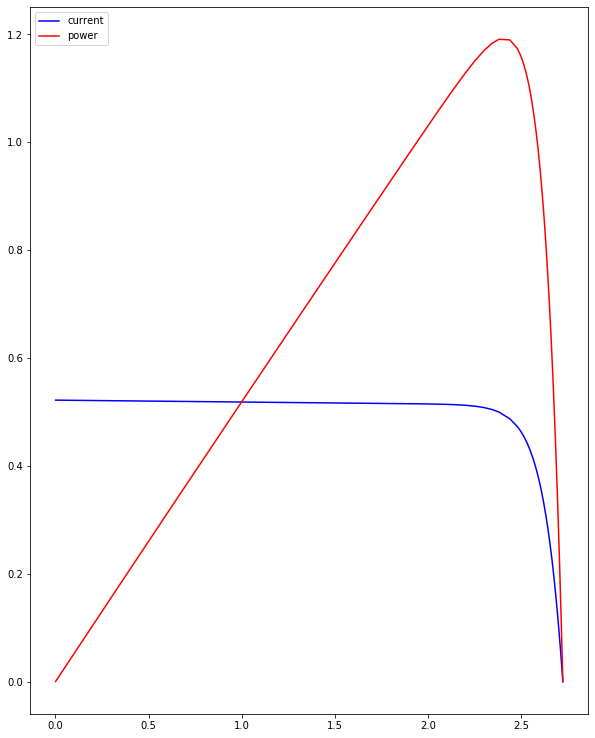

In [7]:
import time

tstart = time.time()
res = ztj.iv_curve()
tstop = time.time()

print('Isc: {:.3f} A'.format(res['Isc']))
print('Voc: {:.2f} V'.format(res['Voc']))
ind = res['mpp']
print('MPP: {:.2f} W  ({:.3f} A @ {:.2f} V)'.format(res['pout'][ind], res['aout'][ind], res['vout'][ind]))
print('({} points tested in {:.3f} seconds)'.format(len(res['pout']), tstop - tstart))

print(ztj_specs)

plt.plot(res['vout'], res['aout'], label='current', color='b')
plt.plot(res['vout'], res['pout'], label='power', color='r')
plt.legend()
plt.show()

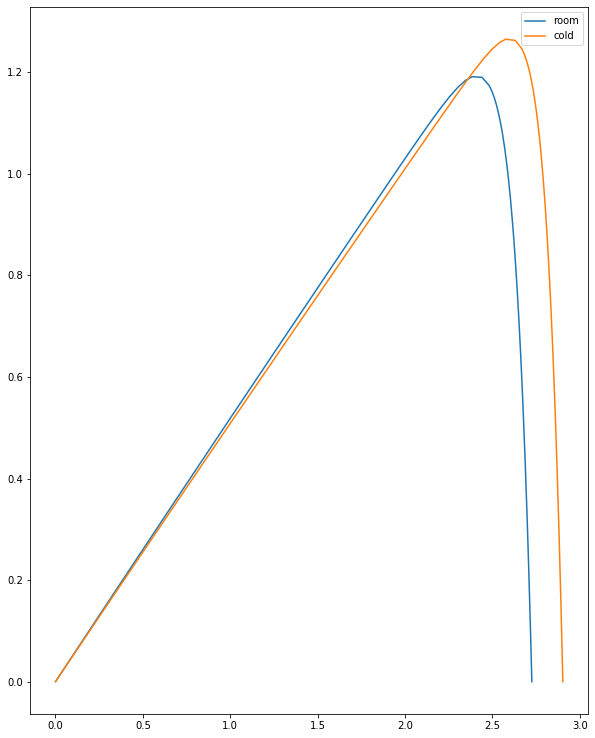

In [8]:
room = ztj.iv_curve()
cold = ztj.iv_curve(270)

plt.plot(room['vout'], room['pout'], label='room')
plt.plot(cold['vout'], cold['pout'], label='cold')
plt.legend()
plt.show()

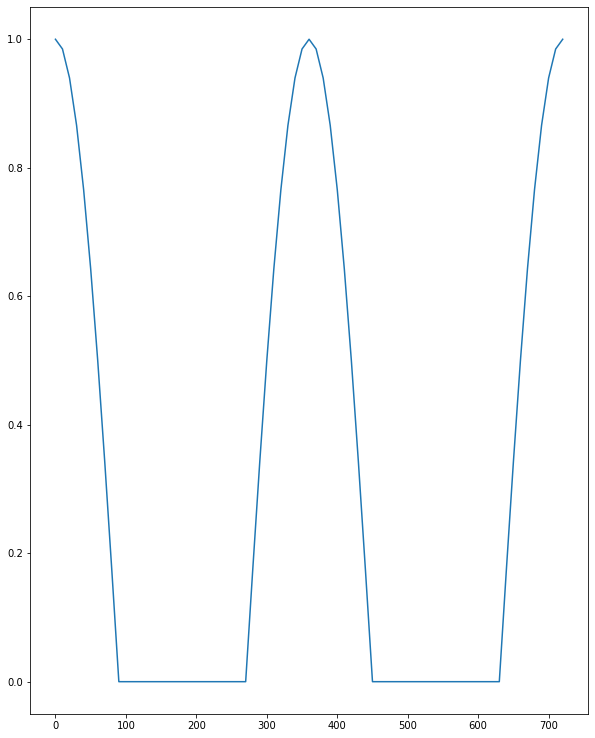

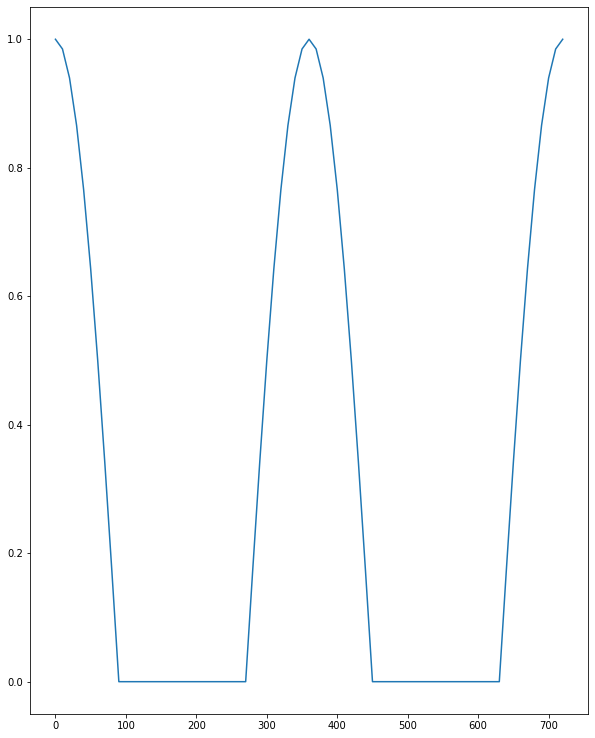

In [11]:
# For the angle of incidence
from math import cos, radians

def angle_coeff(theta, phi):
    # by convention, phi is the angle between y+ (spin axis when shawarma-mode) and the plane normal to the sun vector
    #  theta is the angle between the normal of this cell, and the max alignment with the sun
    if phi < 0:
        phi = 0 - phi
    phi %= 360
    if 90 <= phi <= 270:
        theta += 180
    theta %= 360
    if 90 <= theta <= 270:
        return 0
    return cos(radians(theta)) * cos(radians(phi))

angles = [i * 10 for i in range(73)]
plt.plot(angles, [angle_coeff(i, 0) for i in angles])
plt.show()
plt.plot(angles, [angle_coeff(0, i) for i in angles])



In [13]:
from importlib import reload
reload(pvcells)

<module 'pymodules.pvcells' from '/mnt/c/Users/Patrick Yeon/openlunar/ee-software/notebooks/pymodules/pvcells.py'>

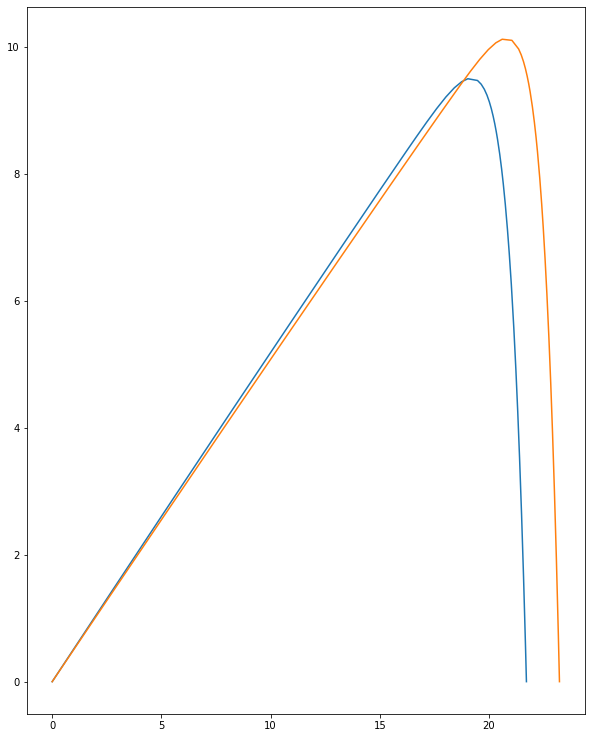

In [17]:
# So we've got a column of, say, 8 cells. A nominal temperature for the column, and a gradient along it.
def add_cell(circuit, specs, name, temp, node1='', node2=''):
    def fmt(s):
        return s + '_' + str(name)
    model = circuit.model(fmt('Dint'), 'D', IS=specs['io'], N=specs['a'],
                          TNOM=(specs['temp'] - zeroC), DTEMP=(temp - specs['temp']))
    bot, mid, top = (node1 or fmt('cell_bot')), fmt('cell_mid'), (node2 or fmt('cell_top'))
    circuit.I(fmt('src'), bot, mid, specs['ipv'])
    circuit.D(fmt('diode'), mid, bot, model=fmt('dint'))
    circuit.R(fmt('sh'), mid, bot, specs['rsh'])
    circuit.R(fmt('s'), mid, top, specs['rs'])
    return (bot, top)

def column_series(tnom, tgrad, theta, phi, specs):
    ckt = Circuit('')
    for i in range(8):
        ypos = i - 3.5
        tcell = tnom + tgrad(ypos)
        cell = pvcells.PVCell(**specs)
        elts = cell.five_elt(tcell)
        elts['ipv'] *= angle_coeff(theta, phi)
        add_cell(ckt, elts, i, tcell, node2='cell_bot_{}'.format(i+1))
    ckt.R('conn', ckt.gnd, 'cell_bot_0', 0.001)
    ckt.R('load', 'cell_bot_8', ckt.gnd, 1)   
    ckt['Rload'].plus.add_current_probe(ckt)
    results = pvcells.PVCell.Sweep_res(ckt, rmin=1e-3, rmax=1e6, resistor='Rload',
                               temp=tnom, voltage='cell_bot_8',
                               current='vrload_plus')
    results['pout'] = [v*a for v,a in zip(results['vout'], results['aout'])]
    results['mpp'] = results['pout'].index(max(results['pout']))
    return results

def tt(y):
    return y

r = column_series(300, tt, 0, 0, ztj_specs)
plt.plot(r['vout'], r['pout'])
r = column_series(270, tt, 0, 0, ztj_specs)
plt.plot(r['vout'], r['pout'])
plt.show()

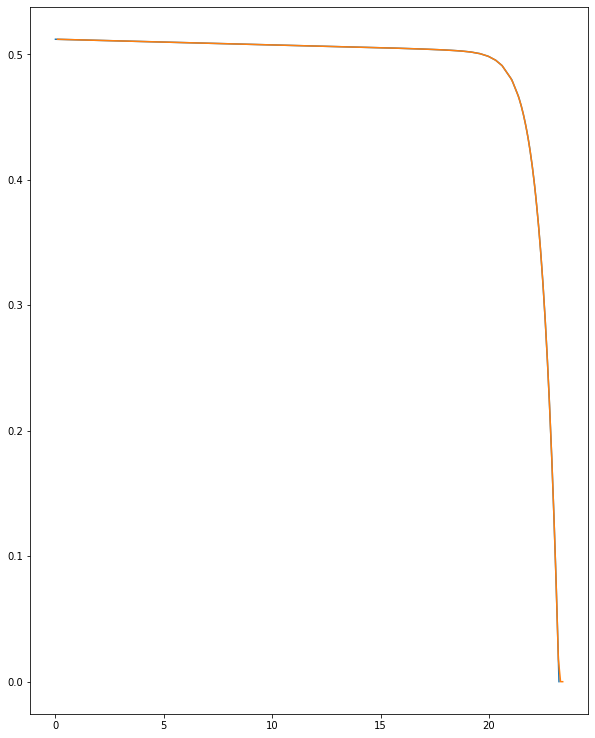

In [18]:
# We will also want to be able to look up current vs. voltage
def current_at(v, cell_iv):
    voltages = cell_iv['vout']
    currents = cell_iv['aout']
    i, j = 0, len(voltages) - 1
    # We're not doing dumb extrapolation
    if v < voltages[0]:
        return currents[0]
    if v > voltages[-1]:
        return 0
    while j - 1 > i:
        mid = (i + j) // 2
        if voltages[mid] > v:
            j = mid
        else:
            i = mid
    # v is in the range (i,j)
    frac = (v - voltages[i]) / (voltages[j] - voltages[i])
    return currents[i] + frac * (currents[j] - currents[i])

plt.plot(r['vout'], r['aout'])
resamp = [0.1 * v for v in range(1,235)]
plt.plot(resamp, [current_at(v, r) for v in resamp])

In [19]:
# let's have a pretend satellite, it's a cylinder with a column of 8 cells every 30 degrees radially
# - the sun is at theta=0, phi=0
# - temperature is 300K - 40 * cos(theta - 180)
# - temperature drops by 10 degrees (linear slope) from the center of the panel to the top/bottom edges

def tgrad(y):
    return (10/3.5) * y
    
panels = {theta: column_series((300 - 40*cos(theta - 180)), tgrad, theta, 0, ztj_specs)
          for theta in range(0, 360, 30) if angle_coeff(theta, 0) > 0.001}

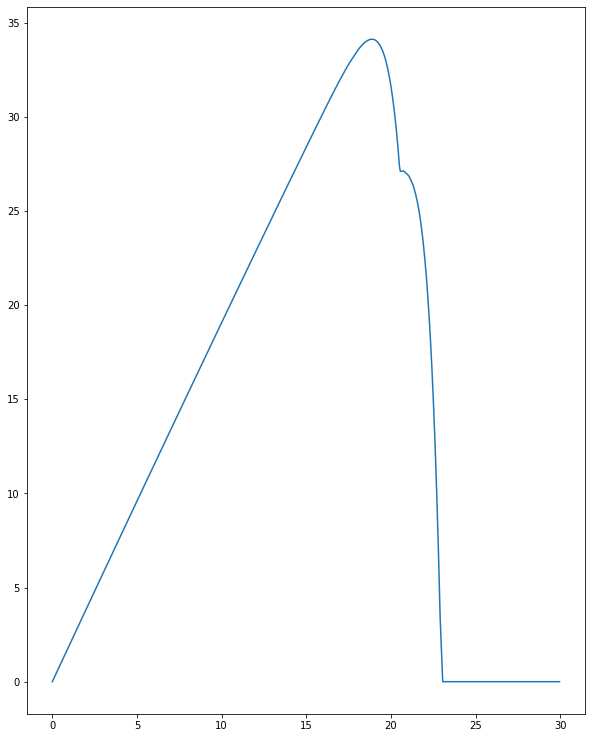

34.13612397788937 36.119791756107425


In [20]:
vsweep = [0.05 * i for i in range(int(30 / 0.05))]
all_a = [sum([current_at(v, panel) for panel in panels.values()]) for v in vsweep]
plt.plot(vsweep, [v*a for v,a in zip(vsweep, all_a)])
plt.show()
print(max([v*a for v,a in zip(vsweep, all_a)]), sum([p['vout'][p['mpp']] * p['aout'][p['mpp']]
                                                     for p in panels.values()]))